In [32]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import math
import scipy.stats as st

In [33]:
import matplotlib.pyplot as plt

### Read cleaned BMRB data from 'CACBHB.csv'

In [69]:
df=pd.read_csv('CACBHB.csv',index_col=0,float_precision=0.2)
tot=len(df)

In [70]:
df.head()

,AccNo,AANo,AANM,C,CA,CB,H,HB,N
0,447,2,THR,170.8,59.2,69.1,8.06,3.740,114.5
1,447,3,PHE,NaN,55.3,41.2,8.58,2.820,124.7
2,447,4,LYS,174.7,54.3,31.2,9.17,1.505,124.1
3,447,5,VAL,NaN,59.1,32.3,9.33,2.030,129.1
4,447,6,THR,171.5,60.4,67.6,9.27,4.210,126.7


### Eliminating outliers

In [71]:
# by setting ranges for ca,cb and hb GLY points gets removed along with outliers.
ca_min=30
ca_max=80
cb_min=10
cb_max=80
hb_min=-1
hb_max=6
df=df[(df['CA'].between(ca_min,ca_max))&(df['CB'].between(cb_min,cb_max)) &(df['HB'].between(hb_min,hb_max))]
outlrs=tot-len(df)
tot,len(df),outlrs

(485378, 428858, 56520)

In [72]:
df.reset_index(inplace=True,drop=True)

In [75]:
# list of all amino acids except 'GLY' and 'PRO'

g= df['AANM'].unique()
g

array(['THR', 'PHE', 'LYS', 'VAL', 'LEU', 'ILE', 'ASN', 'GLU', 'ALA',
       'HIS', 'ASP', 'TYR', 'GLN', 'SER', 'MET', 'ARG', 'CYS', 'TRP'], dtype=object)

In [76]:
# KDE analysis is only in 'CA,CB,HB' chemical shift space. Others are dropped from the table
# The amino acid label 'AA' is retained 
df.drop(['AccNo','AANo','N','H'],axis=1,inplace=True)                                                                                     

In [77]:
df.head()

,AANM,C,CA,CB,HB
0,THR,170.8,59.2,69.1,3.740
1,PHE,NaN,55.3,41.2,2.820
2,LYS,174.7,54.3,31.2,1.505
3,VAL,NaN,59.1,32.3,2.030
4,THR,171.5,60.4,67.6,4.210


### Obtaining the density functions for each amino acid residue seperately 

In [79]:
# density function are calculated in both 2D and 3D. 
# the lists ker and ker3 cosists of the probability density functions.
# this process is very fast so one can create every time.

ker=[] # (CA,CB) Kernel
ker3=[] # (CA,CB,HB) Kernel
for aa in g:
    dfp=df[df['AANM']==aa]
    #2D kernels - (CA,CB)
    values=dfp[['CA','CB']].T.values
    kernel = st.gaussian_kde(values)
    ker.append(kernel)
    
    #3D kernels -(CA,CB,HB)
    values=dfp[['CA','CB','HB']].T.values
    kernel = st.gaussian_kde(values)
    ker3.append(kernel)
    #
    print(aa)

THR
PHE
LYS
VAL
LEU
ILE
ASN
GLU
ALA
HIS
ASP
TYR
GLN
SER
MET
ARG
CYS
TRP


#### Generating KDE values for all the BMRB data is time consuming. For analysis purpose we can prepare it for once and use the same every time. 

In [80]:
# KDE values read from file
dfk=pd.read_csv('kde_cacbhb.csv',index_col=0)

#### We set cutoff for KDE values to retain only meaningful data
Here it is 0.00001

In [81]:
# below 10^-4 made zero
dfk[dfk<0.00001]=0

In [82]:
dfk.head()

,THR,PHE,LYS,VAL,LEU,ILE,ASN,GLU,ALA,HIS,ASP,TYR,GLN,SER,MET,ARG,CYS,TRP
0,0.004605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000174,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.023959,0.000000,0.000000,0.000073,0.000000,0.008851,0.000000,0.0,0.000209,0.067871,0.024754,0.000000,0.000000,0.000000,0.000087,0.004659,0.000000
2,0.000000,0.000000,0.003699,0.000011,0.000000,0.000035,0.000000,0.001413,0.0,0.000640,0.000000,0.000000,0.003341,0.000000,0.002896,0.011348,0.000154,0.000061
3,0.000000,0.000000,0.108081,0.011368,0.000000,0.000587,0.000000,0.002694,0.0,0.000120,0.000000,0.000000,0.001011,0.000000,0.042596,0.004206,0.000362,0.000383
4,0.007781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000103,0.000000,0.000000,0.000000,0.000000


In [83]:
# Pick first five after sorting
# New DataFrame consists of five columns with AA number as per the group dictionary

dfk_as=dfk.apply(np.argsort,axis=1).iloc[:,[-1,-2,-3,-4,-5]]
dfk_s=dfk.apply(np.sort,axis=1).iloc[:,[-1,-2,-3,-4,-5]]

In [84]:
grp=dict(zip(range(len(g)),g))
#grp

In [85]:
# chaging the positions numbers with corresponding AA
dfk_as.replace(grp,inplace=True)

In [86]:
df['1']=dfk_as.iloc[:,0]
df['2']=dfk_as.iloc[:,1]
df['3']=dfk_as.iloc[:,2]
df['4']=dfk_as.iloc[:,3]
df['5']=dfk_as.iloc[:,4]
#
df['1v']=dfk_s.iloc[:,0]
df['2v']=dfk_s.iloc[:,1]
df['3v']=dfk_s.iloc[:,2]
df['4v']=dfk_s.iloc[:,3]
df['5v']=dfk_s.iloc[:,4]

## Now df is completely re-arranged data frame for understanding probable identification
#### For all [ca,cb,hb] chemical shifts we have labelled information under AANM and kernel values arranged in descending order under [1v, 2v, 3v, 4v, 5v] and their corresponding residue under [1,2,3,4,5]

In [93]:
df.head()

,AANM,C,CA,CB,HB,1,2,3,4,5,1v,2v,3v,4v,5v
0,THR,170.8,59.2,69.1,3.740,THR,SER,GLU,PHE,LYS,0.004605,0.000174,0.000000,0.000000,0.000000
1,PHE,NaN,55.3,41.2,2.820,ASP,TYR,PHE,ASN,CYS,0.067871,0.024754,0.023959,0.008851,0.004659
2,LYS,174.7,54.3,31.2,1.505,ARG,LYS,GLN,MET,GLU,0.011348,0.003699,0.003341,0.002896,0.001413
3,VAL,NaN,59.1,32.3,2.030,LYS,MET,VAL,ARG,GLU,0.108081,0.042596,0.011368,0.004206,0.002694
4,THR,171.5,60.4,67.6,4.210,THR,SER,GLU,PHE,LYS,0.007781,0.000103,0.000000,0.000000,0.000000


## Q1: For how many datapoints the first highest kernel valued residue matches with the label?

In [95]:
len(df[df['AANM']==df['1']])/len(df)

0.7703668813453404

## Ans: Its true for 77% of all the data

## Q2: Using first three highest kernel valued residues how many data points can be recognized? 

In [96]:
(len(df[df['AANM']==df['1']]) + len(df[df['AANM']==df['2']]) + len(df[df['AANM']==df['3']]))/ len(df) 

0.9587765647370459

## Ans: 95.8%

## Q3: Residue wise identification percentage   

In [187]:
a1=[]
a2=[]
a3=[]
for aa in g:
    dft=df[df['AANM']==aa]
    a1.append(len(dft[dft['AANM']==dft['1']])*100/len(dft))
    a2.append(len(dft[dft['AANM']==dft['2']])*100/len(dft))
    a3.append(len(dft[dft['AANM']==dft['3']])*100/len(dft))
a1=np.array(a1)
a2=np.array(a2)
a3=np.array(a3)

In [142]:
# positions based on first heighest kernel values
dps=a1.argsort()[::-1]

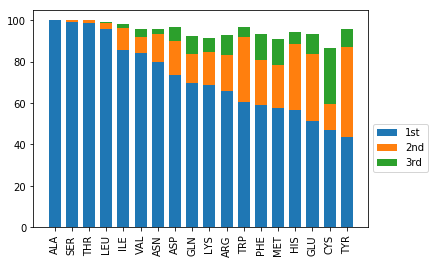

In [160]:
p1=plt.bar(np.arange(18),a1[dps],width=0.7)
p2=plt.bar(np.arange(18),a2[dps],bottom=a1[dps],width=0.7)
p3=plt.bar(np.arange(18),a3[dps],bottom=a1[dps]+a2[dps],width=0.7)
plt.xticks(np.arange(18), g[dps], rotation=90)
plt.legend((p1[0],p2[0],p3[0]),('1st','2nd','3rd'),bbox_to_anchor=(1, 0.5))
plt.show()

## Q4: When can we choose redues of highest kernel values?   

In [206]:
res_1=np.array([len(df[((df['2v']/df['1v'])<dr) & (df['AANM']==df['1'])]) for dr in np.arange(0.0,1,0.01)])

In [207]:
res_n1=np.array([len(df[((df['2v']/df['1v'])<dr) & (df['AANM']!=df['1'])]) for dr in np.arange(0.0,1,0.01)])

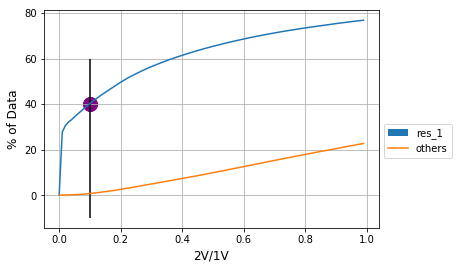

In [250]:
pl=plt.plot(np.arange(0.0,1,0.01), res_1*100/len(df))
p2=plt.plot(np.arange(0.0,1,0.01), res_n1*100/len(df))
plt.vlines(x=0.1, ymin=-10,ymax=60)
plt.xlabel('2V/1V',fontsize='large')
plt.ylabel('% of Data',fontsize='large')
plt.legend((p1[0],p2[0]),('res_1','others'),bbox_to_anchor=(1, 0.5))
plt.scatter( 0.1,40, c='purple',s=200, label='arrow' )
plt.grid()
plt.show()

## Ans: From the above plot, when the second highest value to 1st highest ration is less than 0.1 one can safely choose the residue with highest KDE value.